In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', 50)

# Check the lambdas vs. Coefficients

In [2]:
# Lasso function with various lambda values
def lasso_model(X, y, lam):
    model = Lasso(alpha=lam)
    model.fit(X, y)
    return model

# function to make coefficients with various lambdas
def make_coef_df(filename, lambdas, target):
    # read the data
    df = pd.read_csv("data/processed/"+filename)
    # make X and y
    X = df.drop(["Year_Week", "Phase", "R1-RF", "R2-RF", "R3-RF"], axis=1)
    col_names = X.columns
    y = df[target]
    # standardization
    scaler = StandardScaler().fit(X) 
    X = pd.DataFrame(scaler.transform(X), columns=col_names)
    coefs = []
    for lam in lambdas:
        model = lasso_model(X, y, lam)
        coefs.append(model.coef_)
    coefs = pd.DataFrame(coefs, index=lambdas, columns=X.columns)
    return coefs

# function to make a graph
def plot_func(suptitle):
    global coef_rec, coef_exp, coef_dwt, coef_dep
    fig = plt.figure(figsize=(8, 7))
    ax1 = fig.add_subplot(221, title="Recovery", xscale="log")
    ax2 = fig.add_subplot(222, title="Expansion", xscale="log")
    ax3 = fig.add_subplot(223, title="Downturn", xscale="log")
    ax4 = fig.add_subplot(224, title="Depression", xscale="log")
    ax1.plot(coef_rec)
    ax2.plot(coef_exp)
    ax3.plot(coef_dwt)
    ax4.plot(coef_dep)
    fig.legend(coef_dwt.columns, loc='center right', bbox_to_anchor=(1.1, 0.5))
    fig.supxlabel('Lambdas')
    fig.supylabel('coefficient')
    fig.suptitle('Lambda vs. Coefficients '+suptitle)
    plt.show()

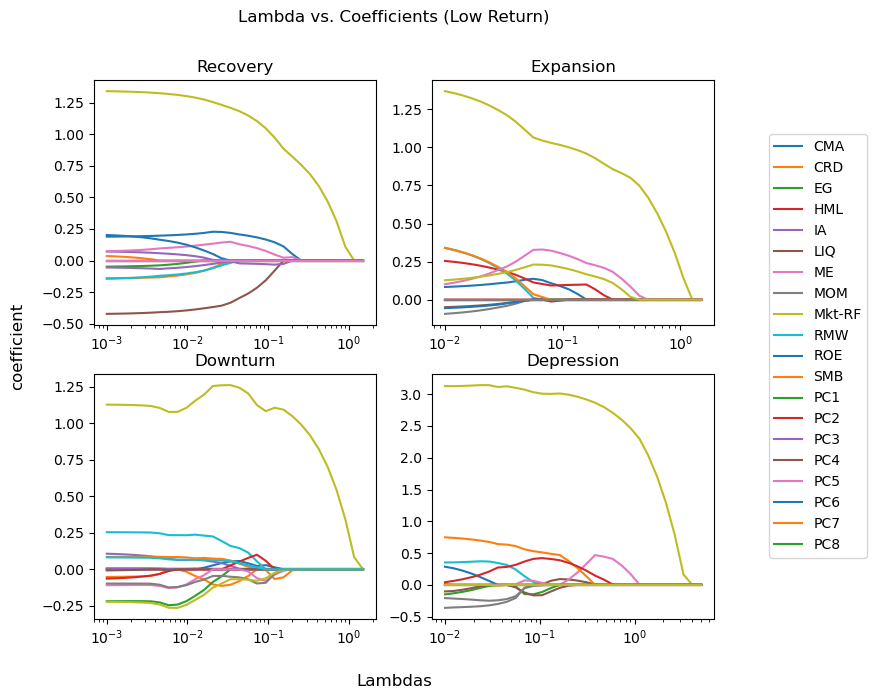

In [3]:
# Low Return
target = "R1-RF"
coef_rec = make_coef_df("recovery_factor_candidates.csv", np.geomspace(start=10**-3, stop=1.5, num=30), target)
coef_exp = make_coef_df("expansion_factor_candidates.csv", np.geomspace(start=10**-2, stop=1.5, num=30), target)
coef_dwt = make_coef_df("downturn_factor_candidates.csv", np.geomspace(start=10**-3, stop=1.5, num=30), target)
coef_dep = make_coef_df("depression_factor_candidates.csv", np.geomspace(start=10**-2, stop=5, num=30), target)
plot_func("(Low Return)") # make a graph

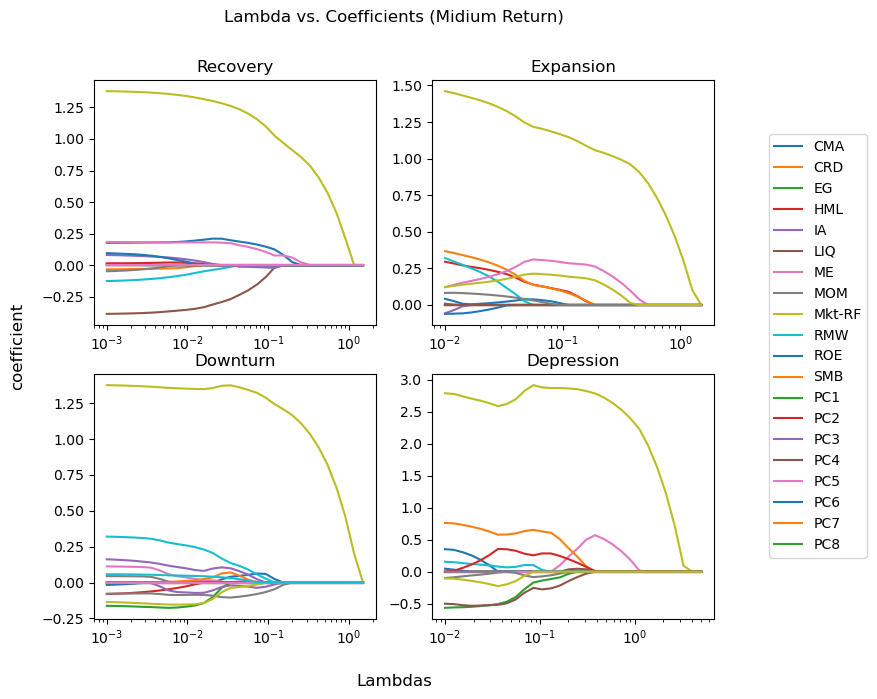

In [4]:
# Midium Return
target = "R2-RF"
coef_rec = make_coef_df("recovery_factor_candidates.csv", np.geomspace(start=10**-3, stop=1.5, num=30), target)
coef_exp = make_coef_df("expansion_factor_candidates.csv", np.geomspace(start=10**-2, stop=1.5, num=30), target)
coef_dwt = make_coef_df("downturn_factor_candidates.csv", np.geomspace(start=10**-3, stop=1.5, num=30), target)
coef_dep = make_coef_df("depression_factor_candidates.csv", np.geomspace(start=10**-2, stop=5, num=30), target)
plot_func("(Midium Return)") # make a graph

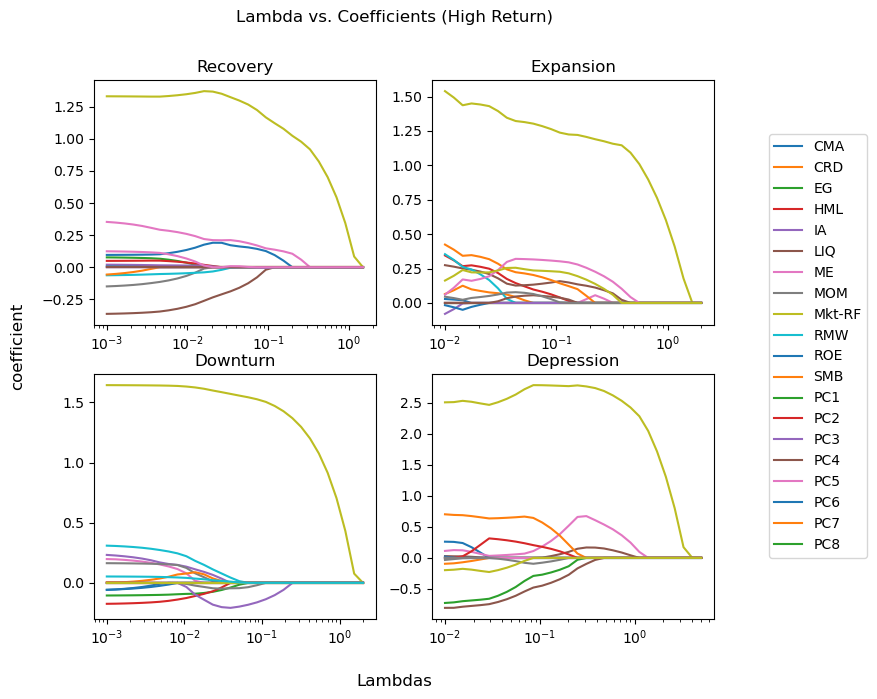

In [5]:
# High Return
target = "R3-RF"
coef_rec = make_coef_df("recovery_factor_candidates.csv", np.geomspace(start=10**-3, stop=1.5, num=30), target)
coef_exp = make_coef_df("expansion_factor_candidates.csv", np.geomspace(start=10**-2, stop=2, num=30), target)
coef_dwt = make_coef_df("downturn_factor_candidates.csv", np.geomspace(start=10**-3, stop=2, num=30), target)
coef_dep = make_coef_df("depression_factor_candidates.csv", np.geomspace(start=10**-2, stop=5, num=30), target)
plot_func("(High Return)") # make a graph

# Make the best models with each cycle and return

In [6]:
# function to calculate adjusted R square
def adj_r2_score(y_true, y_pred, p):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

# function to make the best model and return lambda, constant, coefficients, and adjusted R square in dictionary
def make_lasso_dict(filename, target):
    # read the data
    df = pd.read_csv("data/processed/"+filename)
    
    # make X and y
    X = df.drop(["Year_Week", "Phase", "R1-RF", "R2-RF", "R3-RF"], axis=1)
    y = df[target]

    # make model
    scaler = StandardScaler()
    scaler.fit(X)
    model = LassoCV(alphas=np.geomspace(start=10**-3, stop=1.5, num=30), cv=5)
    model.fit(scaler.transform(X), y)

    # calculate adjusted R square
    y_pred = model.predict(scaler.transform(X))
    adj_r2 = adj_r2_score(y, y_pred, p=X.shape[1])

    return {"lam":model.alpha_, "const":model.intercept_, "coef":model.coef_, "adf_R2":adj_r2}

In [7]:
res = pd.DataFrame(index=["R1-RF", "R2-RF", "R3-RF"], columns=["Rec", "Exp", "Dwt", "Dep"])
filepath_dict = {"Rec":"recovery_factor_candidates.csv", "Exp":"expansion_factor_candidates.csv",\
                 "Dwt":"downturn_factor_candidates.csv", "Dep":"depression_factor_candidates.csv"}
for target in res.index:
    for cycle in res.columns:
        res.at[target, cycle] = make_lasso_dict(filepath_dict[cycle], target)
res.index = ["Low", "Mid", "High"]

In [8]:
idx_names = ["const"] + list(coef_dwt.columns) + ["lambda", "Adj R^2"]
result_df = pd.DataFrame(index=idx_names)
for col in res.columns:
    for i in res.index:
        r = res.loc[i, col]
        result_df.loc["const", col+"-"+i] = r["const"]
        result_df.loc["CMA":"PC8", col+"-"+i] = list(r["coef"]) + [np.nan]*(20-len(r["coef"]))
        result_df.loc["lambda", col+"-"+i] = r["lam"]
        result_df.loc["Adj R^2", col+"-"+i] = r["adf_R2"]
result_df

,Rec-Low,Rec-Mid,Rec-High,Exp-Low,Exp-Mid,Exp-High,Dwt-Low,Dwt-Mid,Dwt-High,Dep-Low,Dep-Mid,Dep-High
const,0.471191,0.749839,1.013470,0.286780,0.476981,0.659894,0.205802,0.363811,0.517284,0.090564,0.262489,0.401138
CMA,0.228223,0.197919,0.161863,0.056556,0.000000,0.000000,0.041278,0.053421,0.000000,0.000018,0.000000,0.000000
CRD,-0.057613,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.045979,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
EG,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.008018,-0.036344,-0.137409
HML,0.000000,0.000000,0.000000,0.097275,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
IA,0.005307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054664,0.000000,0.000000,0.000000,0.000000
LIQ,-0.368861,-0.268780,-0.160148,-0.000000,0.000000,0.097450,-0.000000,-0.000000,0.000000,0.000000,0.034566,0.095919
ME,0.133734,0.174713,0.202636,0.000000,0.000000,0.037333,0.000000,0.014641,0.000000,0.000000,0.230614,0.514849
MOM,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.306349,-0.000000,-0.000000
Mkt-RF,1.256404,1.261888,1.298913,0.993222,1.021878,1.178947,1.205772,1.342924,1.520252,3.109227,2.861342,2.770236
